In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_machine_learning

In [ ]:
!pip install qiskit_aer

In [ ]:
!pip install pylatexenc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from IPython.display import clear_output
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler, BackendSampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler as RuntimeSampler
#from qiskit_ibm_runtime.accounts import AccountNotFoundError
#from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_aer.noise import *
from qiskit.providers.fake_provider import FakeVigo

In [ ]:
#データの準備
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
feature = iris.data
target = iris.target

#学習に使う変数の数
feature_dim = 4

#データを訓練用と検証用に分割
x_train, x_test, y_train, y_test = train_test_split(feature, target, train_size =0.7)
y_train = np.eye(3)[y_train]
y_test = np.eye(3)[y_test]

#正規化
mms = MinMaxScaler((0, 1))
norm_train_data = mms.fit_transform(x_train)
norm_test_data = mms.transform(x_test)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


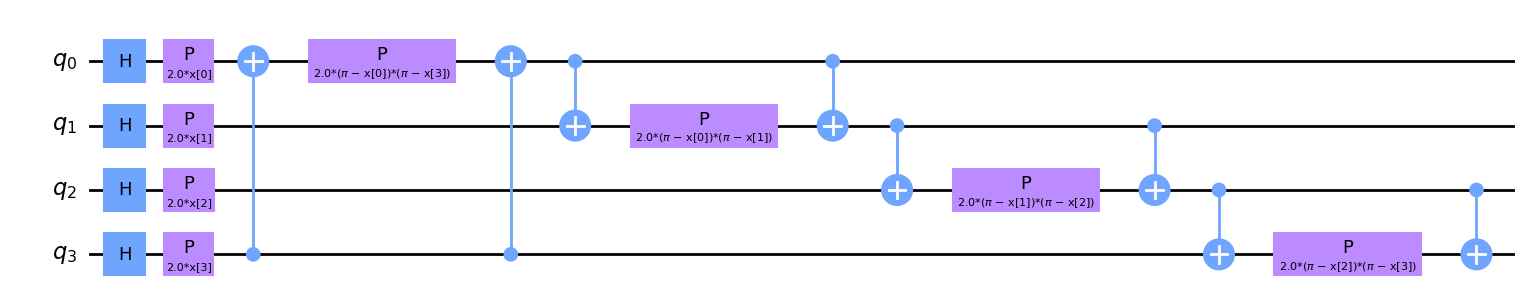

In [ ]:
#量子状態の生成
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')
feature_map.decompose().draw('mpl')

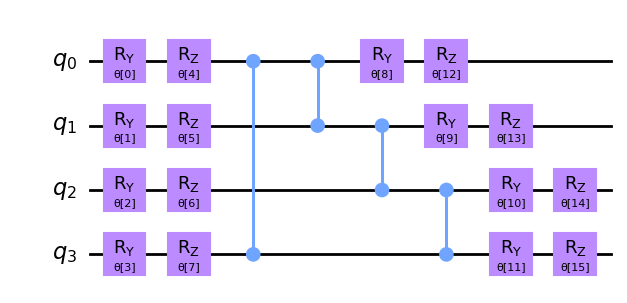

In [ ]:
#変分フォームを用いた状態変換
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='circular', reps=1)
ansatz.decompose().draw('mpl')

In [ ]:
backend = AerSimulator()
sampler = BackendSampler(backend=backend)

In [ ]:
maxiter = 1000
tol = 0.00000000001
optimizer = COBYLA(maxiter=maxiter, disp=True, tol=tol, rhobeg=0.5)
objective_func_vals =[]

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(objective_func_vals)

In [ ]:
#VQCの内容
vqc = VQC(num_qubits=feature_dim,
          feature_map=feature_map,
          ansatz=ansatz,
          loss="squared_error",
          optimizer=optimizer,
          callback=callback_graph,
          sampler=sampler)

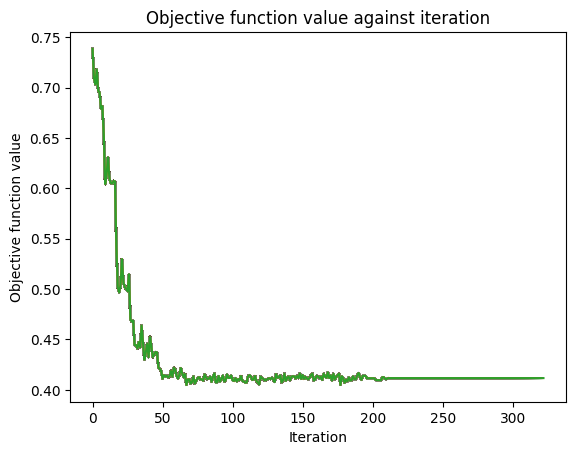

In [ ]:
#学習
start = time.time()
vqc.fit(norm_train_data, y_train)
end = time.time()
time = end - start
train_score = vqc.score(norm_train_data, y_train)
test_score = vqc.score(norm_test_data, y_test)

In [ ]:
print(f'---Classification Train Score: {train_score} ---')
print(f'---Classification Test Score: {test_score} ---')
print(f'Time: {time}')
print(f'Objective Function Values: {objective_func_vals[322]}')

---Classification Train Score: 0.780952380952381 ---
---Classification Test Score: 0.6444444444444445 ---
Time: 115.031094789505
Objective Function Values: 0.4116163889567057


In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw('mpl')

In [ ]:
transpiled_circuit = transpile(qc, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)